### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# Load Cleaned data
df = pd.read_csv('../data/telco-churn-cleaned.csv')
print(f"Data: {df.shape}")
print(f"Churn distribution:\n{df['Churn'].value_counts()}")
print(f"\nChurn Rate: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")

Data: (7043, 21)
Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


In [3]:
df_model = df.copy()

# Drop columns that are not useful (Customer ID)
df_model = df_model.drop('customerID', axis=1)

# Convert "Churn" column: Yes=1, No=0
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

# Categorical and numerical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Numerical columns (4): ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']


#### Encode Categorical variables

In [4]:
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")

Shape after encoding: (7043, 31)


#### Train-Test Split

In [5]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y #ensure the churn distribution is balanced and Train and test 
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain churn distribution:\n{y_train.value_counts()}")
print(f"\nTest churn distribution:\n{y_test.value_counts()}")

Training set: (5634, 30)
Test set: (1409, 30)

Train churn distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64

Test churn distribution:
Churn
0    1035
1     374
Name: count, dtype: int64


In [6]:
scaler = StandardScaler()

numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Scaling complete!")
print(f"\nScaled features sample (first 3 rows):")
print(X_train[numerical_features].head(3))

Scaling complete!

Scaled features sample (first 3 rows):
      SeniorCitizen    tenure  MonthlyCharges  TotalCharges
3738      -0.441773  0.102371       -0.521976     -0.262257
3151      -0.441773 -0.711743        0.337478     -0.503635
4860      -0.441773 -0.793155       -0.809013     -0.749883


#### Model 1: Logistic Regression

In [7]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


LOGISTIC REGRESSION RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1035
       Churn       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC Score: 0.8422


##### Explanation:
- Precision (66%): Of the customers we predicted would churn only 66% actually churned. The rest didn't.
- Recall (56%): Of the customers who actually churned, we only correctly identified 56%.
- Accuracy (81%): We are correctly predicting 81% of our customers, but that's misleading because even if we predicted nobody would churn out, we would still have an accuracy of ~73%, because only ~27% customers churned.
- ROC-AUC Score (0.84): Measures how well we are able to separate the churned vs non-churned

#### Model 2: Random Forest

In [20]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=20
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"Random Forest ROC-AUC:       {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


RANDOM FOREST RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.91      0.87      1035
       Churn       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409


ROC-AUC Score: 0.8426

MODEL COMPARISON
Logistic Regression ROC-AUC: 0.8422
Random Forest ROC-AUC:       0.8426


The ROC-AUC score is a tiny bit better but the Recall has actually dropped from 56% to 52%. 

**Feature Importance** from Random Forest

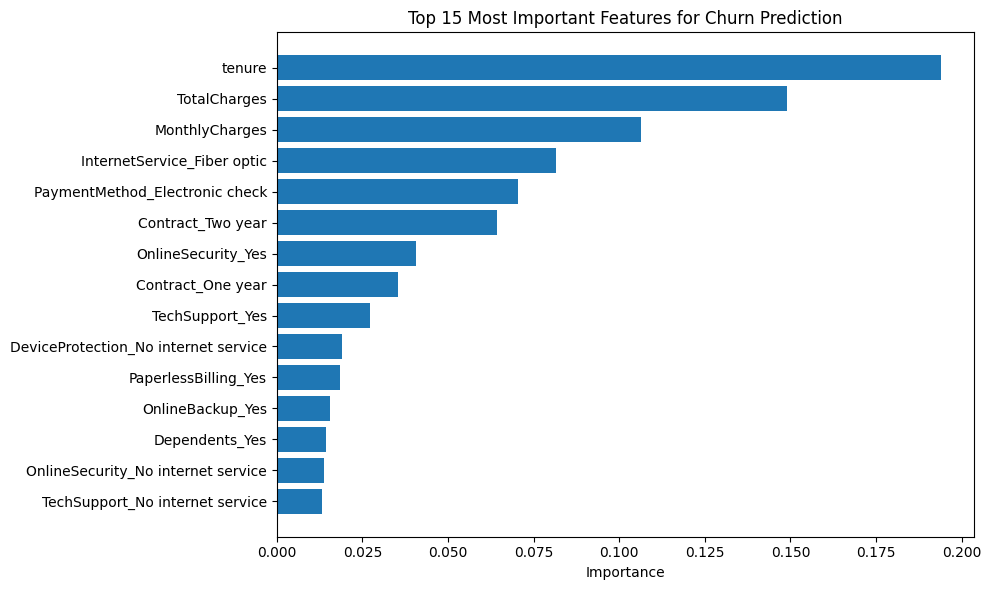


Top 10 Features:
                                 feature  importance
1                                 tenure    0.194023
3                           TotalCharges    0.149095
2                         MonthlyCharges    0.106491
10           InternetService_Fiber optic    0.081456
28        PaymentMethod_Electronic check    0.070549
25                     Contract_Two year    0.064291
13                    OnlineSecurity_Yes    0.040693
24                     Contract_One year    0.035403
19                       TechSupport_Yes    0.027344
16  DeviceProtection_No internet service    0.019178


In [15]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 15 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10))

In [11]:
# Models
joblib.dump(lr_model, '../models/logistic_regression_model.pkl')
joblib.dump(rf_model, '../models/random_forest_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Feature names 
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')

print("Models saved successfully!")
print(f"- Logistic Regression: models/logistic_regression_model.pkl")
print(f"- Random Forest: models/random_forest_model.pkl")
print(f"- Scaler: models/scaler.pkl")
print(f"- Feature names: models/feature_names.pkl")

Models saved successfully!
- Logistic Regression: models/logistic_regression_model.pkl
- Random Forest: models/random_forest_model.pkl
- Scaler: models/scaler.pkl
- Feature names: models/feature_names.pkl


##### Fix Class Imabalance

In [16]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {y_train.value_counts()}")
print(f"\nBalanced training set: {y_train_balanced.value_counts()}")

Original training set: Churn
0    4139
1    1495
Name: count, dtype: int64

Balanced training set: Churn
0    4139
1    4139
Name: count, dtype: int64


#### Model 3: XGBoost + SMOTE

In [19]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("XGBOOST RESULTS (with SMOTE)")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"Random Forest ROC-AUC:       {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"XGBoost (SMOTE) ROC-AUC:     {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")


XGBOOST RESULTS (with SMOTE)

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.76      0.82      1035
       Churn       0.52      0.71      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.75      0.76      1409


ROC-AUC Score: 0.8241

MODEL COMPARISON
Logistic Regression ROC-AUC: 0.8422
Random Forest ROC-AUC:       0.8426
XGBoost (SMOTE) ROC-AUC:     0.8241


In [23]:
# Save XGBoost model and the SMOTE-balanced data info
xgb_config = {
    'model': xgb_model,
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'trained_with_smote': True
}

joblib.dump(xgb_config, '../models/xgboost_smote_model.pkl')
joblib.dump(xgb_model, '../models/xgboost_model.pkl')

print("XGBoost model saved!")
print(f"Model: XGBoost with SMOTE")
print(f"Expected performance: 71% recall, 52% precision, 0.824 ROC-AUC")

XGBoost model saved!
Model: XGBoost with SMOTE
Expected performance: 71% recall, 52% precision, 0.824 ROC-AUC


#### Model 4: Logictic Regression + Tuned Threshold

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

target_recall = 0.70 #Same as XGBoost
idx = np.argmin(np.abs(recalls - target_recall))
optimal_threshold = thresholds[idx]

print(f"Optimal threshold for ~70% recall: {optimal_threshold:.3f}")
print(f"At this threshold - Recall: {recalls[idx]:.3f}, Precision: {precisions[idx]:.3f}")

y_pred_lr_tuned = (y_pred_proba_lr >= optimal_threshold).astype(int)

print("\n" + "="*50)
print("LOGISTIC REGRESSION (Tuned Threshold)")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_tuned, target_names=['No Churn', 'Churn']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# Model Comparsions
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression (default):    ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}, Churn Recall: 56%, Precision: 66%")
print(f"XGBoost (SMOTE):                  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}, Churn Recall: 71%, Precision: 52%")

Optimal threshold for ~70% recall: 0.353
At this threshold - Recall: 0.701, Precision: 0.544

LOGISTIC REGRESSION (Tuned Threshold)

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.79      0.83      1035
       Churn       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409


ROC-AUC Score: 0.8422

FINAL MODEL COMPARISON
Logistic Regression (default):    ROC-AUC: 0.8422, Churn Recall: 56%, Precision: 66%
XGBoost (SMOTE):                  ROC-AUC: 0.8241, Churn Recall: 71%, Precision: 52%


In [24]:
# Save the optimal threshold along with the model
model_config = {
    'model': lr_model,
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'optimal_threshold': optimal_threshold
}

joblib.dump(model_config, '../models/best_model_config.pkl')
joblib.dump(lr_model, '../models/best_model.pkl')

print("Best model saved!")
print(f"Model: Logistic Regression")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Expected performance: 70% recall, 54% precision, 0.842 ROC-AUC")

Best model saved!
Model: Logistic Regression
Optimal threshold: 0.353
Expected performance: 70% recall, 54% precision, 0.842 ROC-AUC
